In [1]:
import tensorflow as tf
import tensorflow.contrib.slim as slim
import tensorflow.contrib.slim.nets as nets

sess = tf.InteractiveSession()

In [3]:
imageSize = ( 299, 299, 3 )
inputImage = tf.Variable( tf.zeros( imageSize ) )

In [4]:
def loadInception( image, reuse ):
    preprocessedImage = tf.multiply( tf.subtract( tf.expand_dims( image, 0 ), 0.5 ), 2.0 )
    arg_scope = nets.inception.inception_v3_arg_scope(weight_decay=0.0)
    with slim.arg_scope( arg_scope ):
        logits, _ =  nets.inception.inception_v3(
            preprocessedImage, 1001, is_training=False, reuse=reuse )
        logits = logits[ :, 1: ] #Ignore background class
        probs = tf.nn.softmax( logits ) #Softmax
    return logits, probs

In [5]:
logits, probs = loadInception( inputImage, reuse=False )

INFO:tensorflow:Scale of 0 disables regularizer.


In [11]:
import tempfile
from urllib import urlretrieve
import tarfile
import os

data_dir = tempfile.mkdtemp()
inception_tarball, _ = urlretrieve(
    'http://download.tensorflow.org/models/inception_v3_2016_08_28.tar.gz')
tarfile.open(inception_tarball, 'r:gz').extractall(data_dir)

In [12]:
restore_vars = [
    var for var in tf.global_variables()
    if var.name.startswith('InceptionV3/')
]
saver = tf.train.Saver(restore_vars)
saver.restore(sess, os.path.join(data_dir, 'inception_v3.ckpt'))

INFO:tensorflow:Restoring parameters from /var/folders/y6/rsv35_lj0hv98_bnrjzppt180000gn/T/tmpCY6edF/inception_v3.ckpt


In [13]:
import json
import matplotlib.pyplot as plt

imagenet_json, _ = urlretrieve(
    'http://www.anishathalye.com/media/2017/07/25/imagenet.json')
with open(imagenet_json) as f:
    imagenet_labels = json.load(f)

In [27]:
def classifyImage( image, correct_class=None, target_class=None ):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 8))
    fig.sca(ax1)
    p = sess.run(probs, feed_dict={ inputImage: image })[0]
    print( p.shape )
    ax1.imshow(img)
    fig.sca(ax1)
    
    topk = list(p.argsort()[-10:][::-1])
    topprobs = p[topk]
    barlist = ax2.bar(range(10), topprobs)
    if target_class in topk:
        barlist[topk.index(target_class)].set_color('r')
    if correct_class in topk:
        barlist[topk.index(correct_class)].set_color('g')
    plt.sca(ax2)
    plt.ylim([0, 1.1])
    plt.xticks(range(10),
               [imagenet_labels[i][:15] for i in topk],
               rotation='vertical')
    fig.subplots_adjust(bottom=0.2)
    plt.show()

In [28]:
import PIL
import numpy as np

img_path, _ = urlretrieve('http://www.anishathalye.com/media/2017/07/25/cat.jpg')
img_class = 281
img = PIL.Image.open(img_path)
big_dim = max(img.width, img.height)
wide = img.width > img.height
new_w = 299 if not wide else int(img.width * 299 / img.height)
new_h = 299 if wide else int(img.height * 299 / img.width)
img = img.resize((new_w, new_h)).crop((0, 0, 299, 299))
img = (np.asarray(img) / 255.0).astype(np.float32)

(1000,)


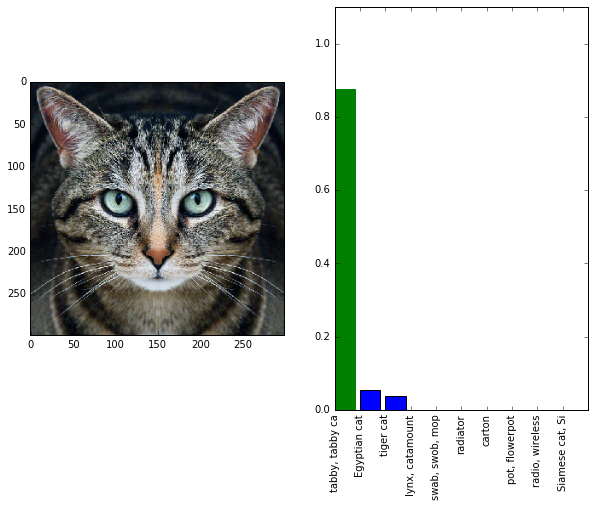

In [30]:
%matplotlib inline
classifyImage(img, correct_class=img_class)

In [33]:
'''Initialization'''
x = tf.placeholder( tf.float32, [ 299, 299, 3 ] )
x_hat = inputImage
assign_op = tf.assign( x_hat, x )

'''Gradient descent'''
learning_rate = tf.placeholder( tf.float32, () )
y_hat = tf.placeholder( tf.int32, () )
labels = tf.one_hot( y_hat, 1000 )
loss = tf.nn.softmax_cross_entropy_with_logits( logits=logits, labels=[labels] )
optimizer = tf.train.GradientDescentOptimizer( learning_rate ).minimize(
    loss, var_list=[ x_hat ] )

'''Projection'''
epsilon = tf.placeholder( tf.float32, () )

below = x - epsilon
above = x + epsilon
projected = tf.clip_by_value( tf.clip_by_value( x_hat, below, above ), 0, 1 )
with tf.control_dependencies( [ projected ] ):
    projected_step = tf.assign( x_hat, projected )

In [41]:
epsilon_val = 2./299.
num_steps = 100
target_target_class = 928 
lr_val = 1e-1

sess.run( assign_op, feed_dict={ x:img } )
for epoch in range( num_steps ):
    feed_dict = { learning_rate:lr_val, y_hat:target_target_class }
    _, loss_val = sess.run( [ optimizer, loss ], feed_dict=feed_dict )
    feed_dict = { epsilon:epsilon_val, x:img }
    sess.run( [ projected_step ], feed_dict=feed_dict )
    
    if( epoch % 10 == 0 ):
        print( "Loss at epoch {} is: {}".format( epoch, loss_val ) )

adv_example = x_hat.eval()

Loss at epoch 0 is: [ 10.37020206]
Loss at epoch 10 is: [ 1.6868577]
Loss at epoch 20 is: [ 0.20703085]
Loss at epoch 30 is: [ 0.12188579]
Loss at epoch 40 is: [ 0.08926343]
Loss at epoch 50 is: [ 0.07259579]
Loss at epoch 60 is: [ 0.06175818]
Loss at epoch 70 is: [ 0.05459124]
Loss at epoch 80 is: [ 0.04900524]
Loss at epoch 90 is: [ 0.0447453]


(1000,)


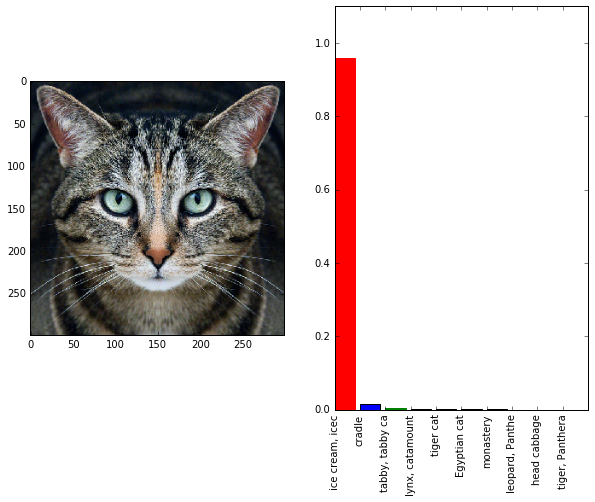

In [42]:
classifyImage(adv_example, correct_class=img_class, target_class=target_target_class)